In [1]:
import pandas as pd
import numpy as np
import csv
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import xgboost as xgb
import scipy
from geopy import distance
import geopy
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn import preprocessing


%matplotlib inline
sns.set()
plt.rcParams['figure.figsize'] = [16, 10]

#### Read Data

In [2]:
PATH_TRAIN_DATASET = './data/train.csv'
PATH_TEST_DATASET = './data/test.csv'
PATH_SAMPLE_SUMBISSION = './data/sample_submission.csv'

In [3]:
df_test = pd.read_csv(PATH_TEST_DATASET, infer_datetime_format=True, parse_dates=['pickup_datetime'],  index_col='id')
df_train = pd.read_csv(PATH_TRAIN_DATASET, infer_datetime_format=True,parse_dates=['pickup_datetime'], index_col='id')
df_sample_submission = pd.read_csv(PATH_SAMPLE_SUMBISSION)
df_original_train = df_train.copy()
df_original_test = df_test.copy()

#### A brief description of the data

As mentioned in the challenge's page, the provided training dataset contains the following fields, as can be verified bellow:

- `id` - a unique identifier for each trip
- `vendor_id` - a code indicating the provider associated with the trip record
- `pickup_datetime` - date and time when the meter was engaged
- `dropoff_datetime` - date and time when the meter was disengaged
- `passenger_count` - the number of passengers in the vehicle (driver entered value)
- `pickup_longitude` - the longitude where the meter was engaged
- `pickup_latitude` - the latitude where the meter was engaged
- `dropoff_longitude` - the longitude where the meter was disengaged
- `dropoff_latitude` - the latitude where the meter was disengaged
- `store_and_fwd_flag` - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server -`Y`=store and forward; `N`=not a store and forward trip
- `trip_duration` - duration of the trip in seconds

In [4]:
df_train.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration'],
      dtype='object')

In [5]:
df_train.head(5)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id,,,,,,,,,,
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


#### No Null Columns

It's important to notice that the provided database has been already preprocessed and cleaned, so no null values can be found in the base.

In [6]:
df_train.isnull().sum()

vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

## Analyzing the whole Dataset

#### Prepare the data for analysis

Before the analysis, a few steps must be done to prepare the data. Also, the dropoff_datetime column will be dropped because it's redundant since we have the trip_duration.

In [7]:
df_train['pickup_datetime'] = df_train['pickup_datetime'].dt.to_pydatetime()
df_test['pickup_datetime'] = df_test['pickup_datetime'].dt.to_pydatetime()
df_train.drop('dropoff_datetime', axis=1, inplace=True)

#### Trip Duration

Since trip duration is the target variable, it will be the first to be checked. After aplying the describe function, a few strange values appear, like the min and max values, 1s and 3526282s (almost 980h) respectively. Trips with a such a low or high values for duration can decrease the accuracy of our model.

In [8]:
df_train['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

To get rid of the outliers, lets apply the the [Interquartile Range](https://en.wikipedia.org/wiki/Interquartile_range) technique

In [9]:
Q1 = df_train['trip_duration'].quantile(0.25)
Q3 = df_train['trip_duration'].quantile(0.75)
IQR = Q3 - Q1
df_train = df_train[~((df_train['trip_duration'] < (Q1 - 1.5 * IQR)) |(df_train['trip_duration'] > (Q3 + 1.5 * IQR)))]
df_train['trip_duration'].describe()

count    1.384424e+06
mean     7.317026e+02
std      4.481081e+02
min      1.000000e+00
25%      3.840000e+02
50%      6.320000e+02
75%      9.910000e+02
max      2.092000e+03
Name: trip_duration, dtype: float64

Even applying the IQR technique, the minimum value for a trip duration keeps very low, so values bellow 90 seconds will also be disconsidered.

In [10]:
df_train = df_train[df_train['trip_duration'] > 1]
df_train = df_train[df_train['trip_duration'] < 7200]

/home/falkets/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


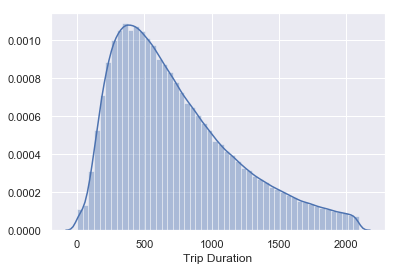

In [11]:
sns.distplot(df_train['trip_duration'], axlabel='Trip Duration')

#### Analyzing the Lat-Long Columns

To understand the distribution we must plot the values for each of the Latitude and Longitude provided. From the graph is possible to see that there are some datapoints from trips starting and finishing outside NYC.

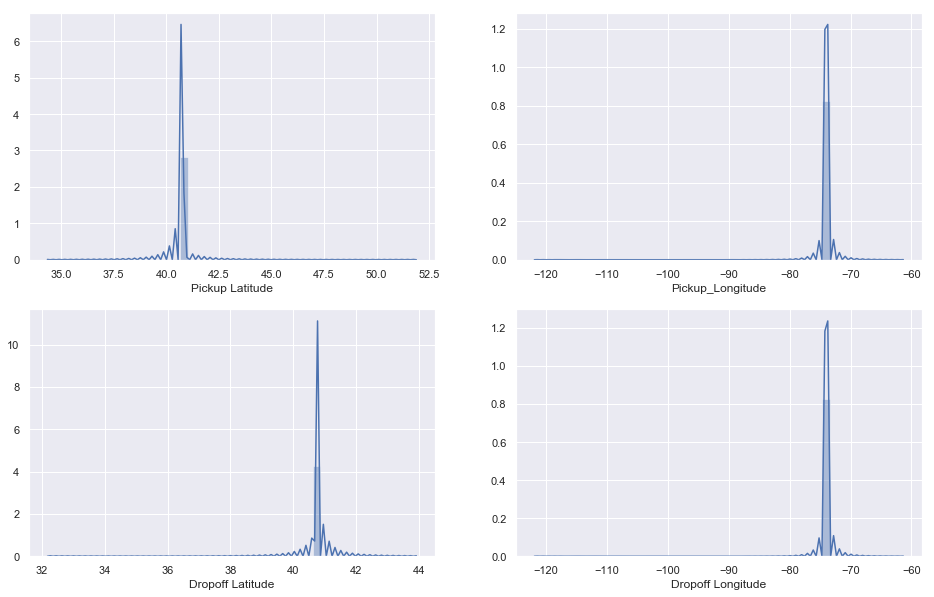

In [12]:
def plot_lat_long(df_data):
    fig, ax = plt.subplots(2,2,figsize=(16, 10), sharex=False, sharey = False)
    sns.distplot(df_data['pickup_latitude'], axlabel = 'Pickup Latitude',ax=ax[0,0])
    sns.distplot(df_data['pickup_longitude'], axlabel = 'Pickup_Longitude', ax=ax[0,1])
    sns.distplot(df_data['dropoff_latitude'], axlabel = 'Dropoff Latitude', ax=ax[1, 0])
    sns.distplot(df_data['dropoff_longitude'], axlabel = 'Dropoff Longitude', ax=ax[1, 1])
    plt.show()
plot_lat_long(df_train)

#### Drop Values Starting or Finishing out of New York City

Select values only within the NYC bounding Box

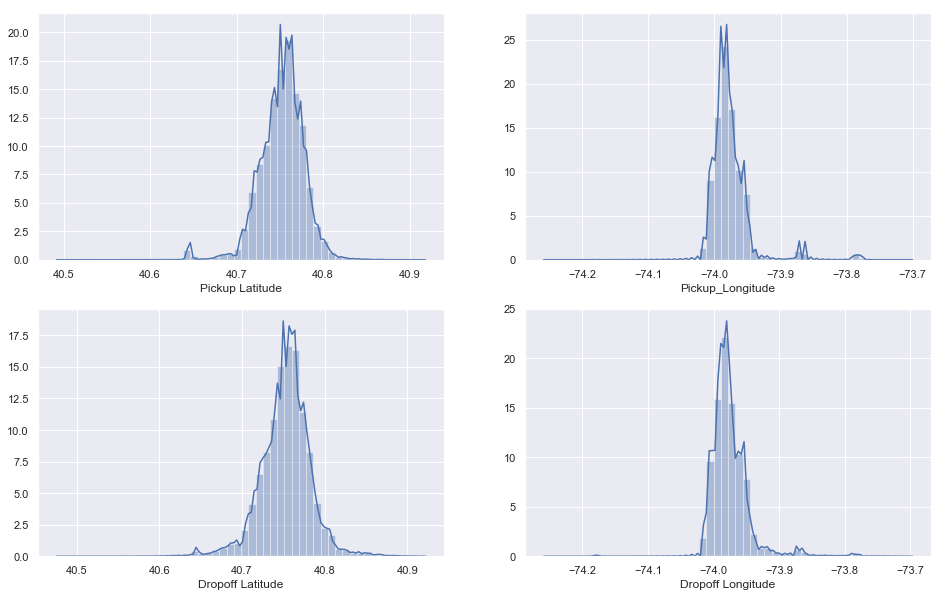

In [13]:
NYC_BOUNDING_BOX = [(40.4774,-74.2589), ( 40.9176, -73.7004)]

filter_lat_long = df_train['pickup_latitude'] < NYC_BOUNDING_BOX[1][0]
filter_lat_long &= df_train['pickup_latitude'] > NYC_BOUNDING_BOX[0][0]
filter_lat_long &= df_train['pickup_longitude'] < NYC_BOUNDING_BOX[1][1]
filter_lat_long &= df_train['pickup_longitude'] > NYC_BOUNDING_BOX[0][1]

filter_lat_long &= df_train['dropoff_latitude'] < NYC_BOUNDING_BOX[1][0]
filter_lat_long &= df_train['dropoff_latitude'] > NYC_BOUNDING_BOX[0][0]
filter_lat_long &= df_train['dropoff_longitude'] < NYC_BOUNDING_BOX[1][1]
filter_lat_long &= df_train['dropoff_longitude'] > NYC_BOUNDING_BOX[0][1]

df_train = df_train[filter_lat_long]

plot_lat_long(df_train)

#### Extracting New Features: DIstance and Average Speed

Two more features will be added using the fields provided. Since we have the coorinates from the pickup and dropoff points, we can calculate the distance between points. The distance function chosen for that is the Manhattan Distance, City Block distance or [Taxicab geometry](https://en.wikipedia.org/wiki/Taxicab_geometry). The final distance is given in Kilometers

The other feature is the average speed for the whole route, for that we will use the distance obtained in the previous step and the trip duration. The average speed will be in Kilometer per hour


In [14]:
NYC_LAT_KILOMETER_PER_DEGREE = geopy.distance.distance((40.7831, -73.9712),(41.7831, -73.9712)).kilometers
NYC_LON_KILOMETER_PER_DEGREE = geopy.distance.distance((40.7831, -73.9712),(40.7831, -72.9712)).kilometers

NYC_DEGREE_KM = 111.05938787411571

def calculate_city_block_distance(df_data):
    delta_lat = np.absolute(df_data.pickup_latitude - df_data.dropoff_latitude) * NYC_LAT_KILOMETER_PER_DEGREE    
    delta_lon = np.absolute(df_data.pickup_longitude - df_data.dropoff_longitude) * NYC_LON_KILOMETER_PER_DEGREE    
    return delta_lat + delta_lon


df_train['distance'] = calculate_city_block_distance(df_train)
df_train['avg_speed'] = df_train['distance']/(df_train['trip_duration']/3600)

### Analyzing Distance and Average Speed


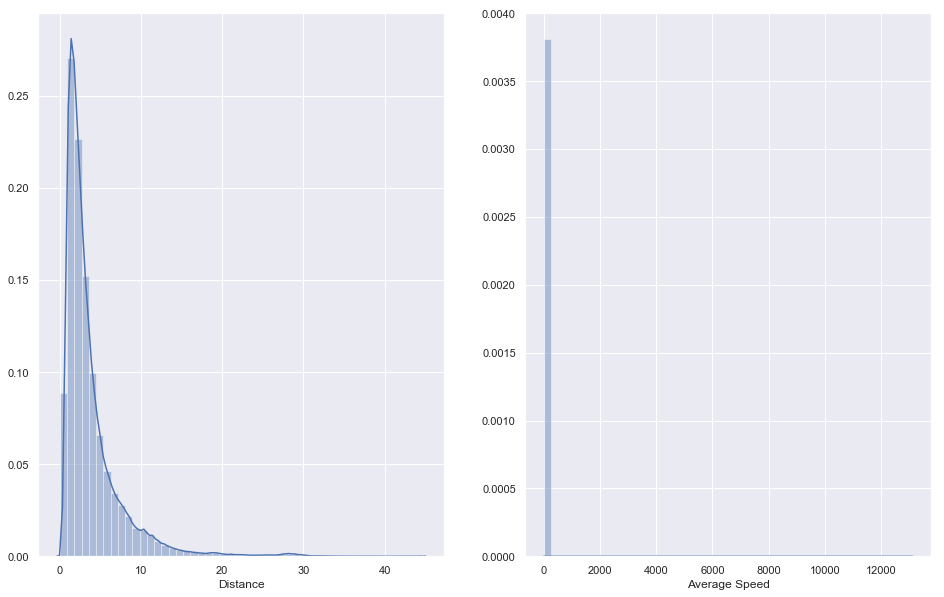

In [15]:
fig, ax = plt.subplots(1,2,figsize=(16, 10), sharex=False, sharey = False)
sns.distplot(df_train['distance'], axlabel = 'Distance',ax=ax[0])
sns.distplot(df_train['avg_speed'], axlabel = 'Average Speed',ax=ax[1])

Even filtering small values for trip duration, we still can find some values that must be removed, since it don't reflects the reality, as can be seen in the graph above, where average speeds of 800 Km/h can be seen. To remove more sporious rows, we'll remove the any value with average speeds greater than 120 Km/h.
Also distances close to 0 can be found and must be removed, for that we'll remove any values smaller than 0.250km

Even filtering the values, is possible to see that the distance distribution is skewed, for this case, we will later apply a logarithmic transformation.

In [16]:
df_train = df_train[df_train['avg_speed'] < 100]
df_train = df_train[df_train['avg_speed'] > 1]
df_train = df_train[df_train['distance'] > .25]
df_train.drop('avg_speed', axis=1, inplace=True)

#### Analyzing Pickup Date

As discussed before, only the pickup date will be used. A few features were created from the pickup datetime, they are justified by the typical behavior that we expect to see in the data, like "Rush Hours" or less traffic at weekends and Holidays. 

To analyze that behavior the following features were created: weekdays, holidays and pickup hour

In [17]:
df_train['pickup_date'] = df_train['pickup_datetime'].dt.date
df_train['pickup_hour'] = df_train['pickup_datetime'].dt.hour
df_train['pickup_weekday'] = df_train['pickup_datetime'].dt.day_name()

holidays = [day.date() for day in calendar().holidays(start=df_train['pickup_date'].min(), end=df_train['pickup_date'].max())]
df_train['holiday'] = df_train['pickup_date'].isin(holidays)
df_train.drop('pickup_date', axis=1, inplace=True)

#### Pickup Hour

In most of cities is expected a well defined behavior regarding populational flow within the city, this way makes a sense to analyze the average trip duration per hour of the day, as can be seen in the graph bellow.

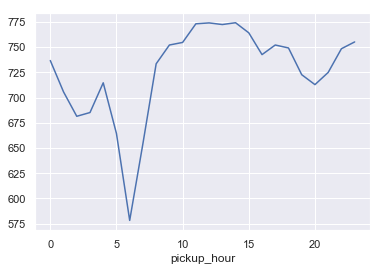

In [18]:
avg_trip_duration_per_pickup_hour = df_train.groupby('pickup_hour')['trip_duration'].mean()
avg_trip_duration_per_pickup_hour.plot()

#### Weekday vs Pickup Hour 

As shown in the graph bellow, different day of the week present a similar behavior, similar to the previous analysis, however the duration of each trip is different for each day of the week and in weekends the curves seen to be slightly shiffted by almost 2 hours.

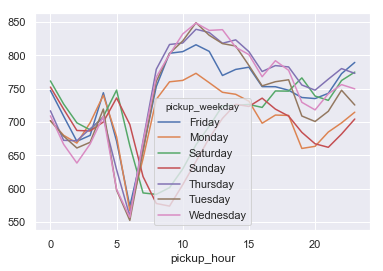

In [19]:
avg_trip_duration_per_weekday = df_train.groupby(['pickup_weekday', 'pickup_hour'])['trip_duration'].mean()
avg_trip_duration_per_weekday.unstack(level=0).plot(subplots=False)

#### Holidays

Applying the same analysis for holidays we have the graph bellow, which shows the average trip duration for a normal day and for a holiday. A similar behavior can be seen for both, however the curve for holiday is slightly shifted by a little more than 2 hours

holiday
False    737.899442
True     652.807536
Name: trip_duration, dtype: float64

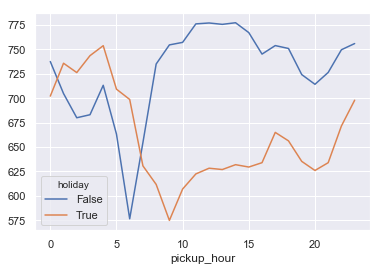

In [20]:
avg_trip_duration_holiday = df_train.groupby(['holiday','pickup_hour'])['trip_duration'].mean()
avg_trip_duration_holiday.unstack(level=0).plot(subplots=False)
df_train.groupby(['holiday'])['trip_duration'].mean()

#### Store and Forward

The store and forward at first look may not give any information about the trip duration, but looking the graph bellow, it becomes clear there is a difference between the two. That difference may be explained by the technologies available to drivers like navigation apps, Internet or more modern cars.

store_and_fwd_flag
N    735.826429
Y    825.277147
Name: trip_duration, dtype: float64

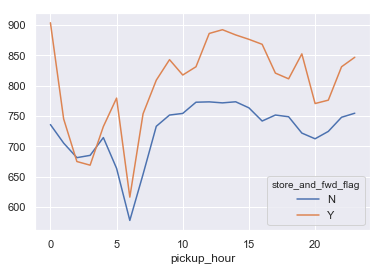

In [21]:
avg_trip_duration_per_store_flag = df_train.groupby(['store_and_fwd_flag','pickup_hour'])['trip_duration'].mean()
avg_trip_duration_per_store_flag.unstack(level=0).plot(subplots=False)
df_train.groupby(['store_and_fwd_flag'])['trip_duration'].mean()

#### Vendor ID

A naive analysis could lead to a misconception regarding the Vendor ID as a not usefull information, but given that technology has changed the private transportation market, a good routing or driver selection algorithm or papyment method can make a great difference in the trip_duration.

vendor_id
1    735.186744
2    737.227505
Name: trip_duration, dtype: float64

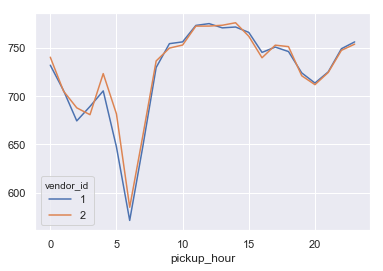

In [22]:
avg_trip_duration_per_store_flag = df_train.groupby(['vendor_id','pickup_hour'])['trip_duration'].mean()
avg_trip_duration_per_store_flag.unstack(level=0).plot(subplots=False)
df_train.groupby(['vendor_id'])['trip_duration'].mean()

#### Number of Passangers

In the same way as the previous analysis, it's worth to check the behavior of the number of passagengers transported and if it might give more infomation about the trip duration.

As can be seen bellow, the graph of number of passangers shows a similar behavior for each number of passangers, but with different values for 

In [23]:
df_train['passenger_count'].value_counts()
df_train = df_train[df_train['passenger_count']>0]

passenger_count
1    730.537404
2    754.938782
3    756.997589
4    761.046567
5    739.444885
6    733.640920
Name: trip_duration, dtype: float64

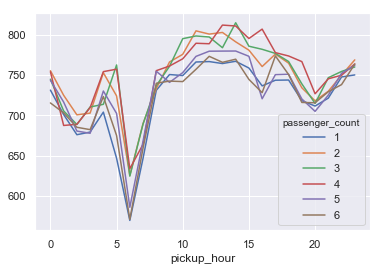

In [24]:
# avg_trip_duration_per_passenger_count = df_train.groupby(['passenger_count'])['trip_duration'].mean()
# avg_trip_duration_per_passenger_count.plot()
avg_trip_duration_per_passenger_count = df_train[df_train['passenger_count']>0].groupby(['passenger_count','pickup_hour'])['trip_duration'].mean()
avg_trip_duration_per_passenger_count.unstack(level=0).plot(subplots=False)
df_train.groupby(['passenger_count'])['trip_duration'].mean()

## Prepare the Data to build the models

After analyzing all the field, create more features and understanding a little more about its distribution, we have to process some of the field to prepare the data, making it more suitable to the models.

### One-hot enconding

To be properly used in supervised learning models the categorical fields independent of its type, must be transformed, since wrong information can be added to the model. One classical example of that are numerical categories where there is a logic relation between the numbers (greater than, sequences, , ratios, etc.) that might not exist in the category itself.

To make the information more

In [25]:
df_train = pd.get_dummies(df_train, columns=['vendor_id', 'passenger_count', 
                                    'store_and_fwd_flag', 'pickup_weekday', 'pickup_hour', 'holiday'])
df_train.drop(['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)
df_train.columns

Index(['trip_duration', 'distance', 'vendor_id_1', 'vendor_id_2',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'store_and_fwd_flag_N', 'store_and_fwd_flag_Y', 'pickup_weekday_Friday',
       'pickup_weekday_Monday', 'pickup_weekday_Saturday',
       'pickup_weekday_Sunday', 'pickup_weekday_Thursday',
       'pickup_weekday_Tuesday', 'pickup_weekday_Wednesday', 'pickup_hour_0',
       'pickup_hour_1', 'pickup_hour_2', 'pickup_hour_3', 'pickup_hour_4',
       'pickup_hour_5', 'pickup_hour_6', 'pickup_hour_7', 'pickup_hour_8',
       'pickup_hour_9', 'pickup_hour_10', 'pickup_hour_11', 'pickup_hour_12',
       'pickup_hour_13', 'pickup_hour_14', 'pickup_hour_15', 'pickup_hour_16',
       'pickup_hour_17', 'pickup_hour_18', 'pickup_hour_19', 'pickup_hour_20',
       'pickup_hour_21', 'pickup_hour_22', 'pickup_hour_23', 'holiday_False',
       'holiday_True'],
      dtype='object')

Also, as could be seen in the analysis above, some field present a very skewed distribution and apply a logarithmic transformation gives a better representation of the data distribution

In [26]:
df_train['trip_duration'] = np.log(df_train['trip_duration'] + 1)
# df_train['distance'] = np.log(df_train['distance'] + 1)

## Training the Model

### Score Function

In the Kaggle competition there is no access to the true value of the trip duration for the test dataset and even though the score function is provided there is no way to calculate it. The only way to have the true score is subtmiting the values obtained when running the model to predict the trip duration for the Test dataset provided.

The score function chosen by the challenge is the [root mean square logarithmic error (RMSLE)](https://www.kaggle.com/c/nyc-taxi-trip-duration#evaluation), which is defined as follows:  

$$ \epsilon = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} ( \log(p_i + 1) - \log(a_i + 1)  )^{2}    }  \;  $$

As the score function is provided we'll implement it and use the Train/Test split to evaluate our model, using it as to compare the models performance.


In [27]:
def kaggle_score(y_true_exp, y_pred_exp):
    y_pred_exp = np.exp(y_pred_exp) - 1
    y_true_exp = np.exp(y_true_exp) - 1
    e_log_square = np.square( np.log(y_pred_exp + 1) - np.log(y_true_exp + 1))
    score = np.sqrt((1/len(y_true_exp)) * np.sum(e_log_square))
    return score


#### Spliting the whole train dataset using train_test_split

In [28]:
from sklearn.model_selection import train_test_split

df_y_train = df_train['trip_duration']
df_X_train = df_train.drop(columns=['trip_duration'])

X_train, X_test, y_train, y_test = train_test_split(df_X_train,
                                                    df_y_train,
                                                    test_size = 0.3,
                                                    random_state = 3)

## Model Selection

### Linear Regression

In [29]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
clf = model.fit(X_train, y_train)
final_score = kaggle_score( y_test, clf.predict(X_test))
                           
print(f'Linear Regression Score: {final_score}')

Linear Regression Score: 0.515646265374078


### Lasso

In [33]:
from sklearn.linear_model import Lasso
model = Lasso(random_state=3)
clf = model.fit(X_train, y_train)
final_score = kaggle_score( y_test, clf.predict(X_test))
                           
print(f'Lasso Score: {final_score}')

Lasso Score: 0.5957329399325557


### Ridge

In [34]:
from sklearn.linear_model import Ridge
model = Ridge(random_state=3)
clf = model.fit(X_train, y_train)
final_score = kaggle_score( y_test, clf.predict(X_test))
                           
print(f'Ridge Score: {final_score}')

Ridge Score: 0.5156462658540855


### ElasticNet

In [35]:
from sklearn.linear_model import ElasticNet
model = ElasticNet(random_state=3, l1_ratio=0.0000001)
clf = model.fit(X_train, y_train)
final_score = kaggle_score( y_test, clf.predict(X_test))
                           
print(f'ElasticNet Score: {final_score}')

ElasticNet Score: 0.532904137273544


### Decision Tree Regressor

In [36]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(random_state=3, max_depth=None, min_samples_split=2)
clf = model.fit(X_train, y_train)
final_score = kaggle_score( y_test, clf.predict(X_test))
                           
print(f'Decision Tree Regressor Score: {final_score}')

Decision Tree Regressor Score: 0.5694438632615723


### Random Forest Regressor

In [32]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=3)
clf = model.fit(X_train, y_train)
final_score = kaggle_score( y_test, clf.predict(X_test))
                           
print(f'Random Forest Regressor Score: {final_score}')

/home/falkets/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Random Forest Regressor Score: 0.4509790992371682


### Gradient Boosting Regressor

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=3)
clf = model.fit(X_train, y_train)
final_score = kaggle_score(y_test, clf.predict(X_test))
                           
print(f'Gradient Boosting Regressor Score: {final_score}')

Gradient Boosting Regressor Score: 0.4073304142923987


### XGBoost

In [38]:
import xgboost as xgb
model = xgb.XGBRegressor(random_state=3)
clf = model.fit(X_train, y_train)
final_score = kaggle_score(y_test, clf.predict(X_test))
                           
print(f'XGBoost Score: {final_score}')

XGBoost Score: 0.4070360921275202


## Fine tunning the best models

**Grid Search**

**Cross Validation**

In [ ]:
all_models_final_score = {}

### Ridge

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

model = Ridge(random_state=3)
scorer = make_scorer(kaggle_score, greater_is_better= False)

parameters = {
    'alpha': [0.5, 5.0, 10.0, 50.0],
    'solver': ['auto', 'lsqr', 'sag', 'svd']
}
clf = GridSearchCV(model, param_grid= parameters, scoring= scorer, verbose= 1, n_jobs= 6, cv= 3)
grid_fit = clf.fit(X_train, y_train)

best_params_ridge = grid_fit.best_params_
best_clf_ridge = grid_fit.best_estimator_
final_score = kaggle_score(y_test, best_clf_ridge.predict(X_test))
all_models_final_score['Ridge'] = final_score

print(f'Ridge best parameters: {best_params}')
print(f'Ridge Score: {final_score}')

### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

model = RandomForestRegressor(random_state=3)
scorer = make_scorer(kaggle_score, greater_is_better= False)

parameters = {
    'max_depth': [15, 50],
    'n_estimators': [20, 100, 200],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2, 6, 10],
    'max_features': ['auto', 'sqrt']
}


clf = GridSearchCV(model, param_grid= parameters, scoring= scorer, verbose= 1, cv= 2, n_jobs=6)
grid_fit = clf.fit(X_train, y_train)

best_params_random_forest = grid_fit.best_params_
best_clf_random_forest = grid_fit.best_estimator_
final_score = kaggle_score(y_test, best_clf_random_forest.predict(X_test))
all_models_final_score['RandomForest'] = final_score

print(f'Gradient Boosting Regressor best parameters: {best_params}')
print(f'Gradient Boosting Regressor  Score: {final_score}')

### Gradient Boosting Regressor

In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

model = GradientBoostingRegressor(random_state=3)
scorer = make_scorer(kaggle_score, greater_is_better= False)

parameters = {
    'max_depth': [3, 5],
    'n_estimators': [100, 200],
    'min_samples_split': [2, 6],
    'learning_rate': [0.1, 1.0]
}

clf = GridSearchCV(model, param_grid= parameters, scoring= scorer, verbose= 1, cv= 2, n_jobs=6)
grid_fit = clf.fit(X_train, y_train)

best_params_gradient_boosting = grid_fit.best_params_
best_clf_gradient_boosting = grid_fit.best_estimator_
final_score = kaggle_score(y_test, best_clf_gradient_boosting.predict(X_test))
all_models_final_score['GradientBoosting'] = final_score

print(f'Gradient Boosting Regressor best parameters: {best_params}')
print(f'Gradient Boosting Regressor  Score: {final_score}')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/luciano/Install/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-3630616f36b2>", line 1, in <module>
    from sklearn.ensemble import GradientBoostingRegressor
  File "/home/luciano/Install/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/__init__.py", line 7, in <module>
    from .forest import RandomForestClassifier
  File "/home/luciano/Install/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py", line 55, in <module>
    from ..metrics import r2_score
  File "/home/luciano/Install/anaconda3/lib/python3.6/site-packages/sklearn/metrics/__init__.py", line 7, in <module>
    from .ranking import auc
  File "/home/luciano/Install/anaconda3/lib/python3.6/site-packages/sklearn/metrics/ranking.py", line 27, in <module>
    from scipy.stats import rankdata
  File "/home/luciano/Install/anaconda3/lib/

KeyboardInterrupt: 

### XGBoost

In [2]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

model = xgb.XGBRegressor(random_state=3)
scorer = make_scorer(kaggle_score, greater_is_better=False)

parameters = {
    'max_depth': [5, 8, 10],
    'n_estimators': [200, 300],
    'learning_rate': [0.05, 0.1,],
    'reg_lambda': [1.0, 5] }

clf = GridSearchCV(model, param_grid= parameters, scoring= scorer, verbose= 1, cv=2, n_jobs=6)
grid_fit = clf.fit(X_train, y_train)

best_params_xgboost = grid_fit.best_params_
best_clf_xgboost = grid_fit.best_estimator_
final_score = kaggle_score(y_test, best_clf_xgboost.predict(X_test))
all_models_final_score['XGBoost'] = final_score

print(f'XGBoost best parameters: {best_params}')
print(f'XGBoost Score: {final_score}')

KeyboardInterrupt: 

## Predicting the Original Test Dataset and submitting to Kaggle

In [31]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=3)
clf = model.fit(df_X_train, df_y_train)
clf.predict()
final_score = kaggle_score( y_test, clf.predict(X_test))
                           
print(f'Random Forest Regressor Score: {final_score}')

/home/falkets/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KeyboardInterrupt: 

In [30]:
df_test['pickup_date'] = df_test['pickup_datetime'].dt.date
df_test['pickup_hour'] = df_test['pickup_datetime'].dt.hour
df_test['pickup_weekday'] = df_test['pickup_datetime'].dt.day_name()

holidays = [day.date() for day in calendar().holidays(start=df_test['pickup_date'].min(), end=df_test['pickup_date'].max())]
df_test['holiday'] = df_test['pickup_date'].isin(holidays)
df_test.drop('pickup_date', axis=1, inplace=True)
df_test['distance'] = calculate_city_block_distance(df_test)

df_test = pd.get_dummies(df_test, columns=['vendor_id', 'passenger_count', 
                                    'store_and_fwd_flag', 'pickup_weekday', 'pickup_hour', 'holiday'])
df_test.drop(['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1, inplace=True)
df_test.columns

Index(['distance', 'vendor_id_1', 'vendor_id_2', 'passenger_count_0',
       'passenger_count_1', 'passenger_count_2', 'passenger_count_3',
       'passenger_count_4', 'passenger_count_5', 'passenger_count_6',
       'passenger_count_9', 'store_and_fwd_flag_N', 'store_and_fwd_flag_Y',
       'pickup_weekday_Friday', 'pickup_weekday_Monday',
       'pickup_weekday_Saturday', 'pickup_weekday_Sunday',
       'pickup_weekday_Thursday', 'pickup_weekday_Tuesday',
       'pickup_weekday_Wednesday', 'pickup_hour_0', 'pickup_hour_1',
       'pickup_hour_2', 'pickup_hour_3', 'pickup_hour_4', 'pickup_hour_5',
       'pickup_hour_6', 'pickup_hour_7', 'pickup_hour_8', 'pickup_hour_9',
       'pickup_hour_10', 'pickup_hour_11', 'pickup_hour_12', 'pickup_hour_13',
       'pickup_hour_14', 'pickup_hour_15', 'pickup_hour_16', 'pickup_hour_17',
       'pickup_hour_18', 'pickup_hour_19', 'pickup_hour_20', 'pickup_hour_21',
       'pickup_hour_22', 'pickup_hour_23', 'holiday_False', 'holiday_True'],
     

In [ ]:
clf.predict(df_test)

In [ ]:
import os
BASE_PATH_KAGGLE_SUBMISISON = './out'

def create_txt_file_for_submission(df_data, file_name):
    
    final_path = os.path.normpath(os.path.join(BASE_PATH_KAGGLE_SUBMISISON,file_name))
    se_subm = pd.Series(data=df_data['trip_duration'],index=df_data.index.values)
    pd.Series.to_csv(path=file_name,
                     sep=',',
                     header=True,
                     na_rep=df_data['trip_duration'].quantile(0.5)                    
                    )
    
    np.savetxt('final_submission/name.csv',se_subm, delimiter=',',
               comments='',
               newline='\n',
               fmt='%s',
               header = 'id,trip_duration')
    